## Overcoming the Curse of Dimensionality
Matthew Rossi

In [49]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

# Load data from https://www.openml.org/d/554
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
X /= 255

X = X.reshape((X.shape[0], -1))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=6000, test_size=1000, shuffle=True
)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size=5000, test_size=1000, shuffle=True
)

### The k-Means classifier
I decided it would be fun to build a really stupid classifier that clusters the data and then decides which cluster represents which class based on majority vote. It's very similar to k-Nearest Neighbors, but more idiotic.

In [50]:
def build_mapping(cluster_labels, true_labels):
    assert len(cluster_labels) == len(true_labels)
    matrix = np.zeros((10,10))
    for cluster, label in zip(cluster_labels, true_labels):
        #builds a confusion matrix
        matrix[int(cluster)][int(label)] += 1
    mapping = {}
    for i in range(10):
        #builds a mapping of which cluster represents which class
        mapping[i] = np.argmax(matrix[i])
    return mapping

def assign_labels(cluster_labels, mapping):
    newlabels = []
    for clus in cluster_labels:
        #relabels according to mapping
        newlabels.append(str(mapping[clus]))
    return newlabels

def accuracy(pred_labels, true_labels):
    assert len(pred_labels) == len(true_labels)
    return np.sum(pred_labels == true_labels) / len(pred_labels)

In [75]:
def test_model(train_data, test_data, dim_reducer=None, prereduce=False, verbose=True):
    X_train, y_train = train_data
    test = (test_data is not None)
    
    if test: X_test, y_test = test_data
    
    if prereduce:
        #it is recommended to reduce to a reasonable number of features before applying t-SNE
        pca = PCA(n_components=50)
        X_train = pca.fit_transform(X_train)
        if test: X_test = pca.transform(X_test)
    
    reduce_time = 0
    if dim_reducer is not None:
        #apply dimensionality reduction
        t0 = time.time()
        X_train = dim_reducer.fit_transform(X_train)
        if test: X_test = dim_reducer.transform(X_test)
        t1 = time.time()
        reduce_time = t1-t0
        if verbose: print("Dimensionality reduction with", dim_reducer, "took %i seconds" % (red_time))
    
    
    if verbose: print("Training on %i datapoints in %i dimensions." % (X_train.shape[0], X_train.shape[1]))
    kmeans = KMeans(n_clusters=10)
    t0 = time.time()
    kmeans.fit(X_train)
    t1 = time.time()
    fit_time = t1-t0
    if verbose: print("Fitting to training data took %2.2f seconds" % (fit_time))
    mapping = build_mapping(kmeans.labels_, y_train)
    train_pred_labels = assign_labels(kmeans.labels_, mapping)
    train_acc = accuracy(train_pred_labels, y_train)
    if verbose: print("Training accuracy:", train_acc)
    
    test_acc = 0
    if test:
        if verbose: print("Testing on", len(X_test), "datapoints.")
        t0 = time.time()
        pred_clusters = kmeans.predict(X_test)
        t1 = time.time()
        pred_time = t1-t0
        if verbose: print("Predicting labels for test data took %2.8f seconds" % (pred_time))
        test_pred_labels = assign_labels(pred_clusters, mapping)
        test_acc = accuracy(test_pred_labels, y_test)
        if verbose: print("Testing accuracy:", test_acc)
    
    return reduce_time, fit_time, train_acc, test_acc

In [52]:
def plot(dims, data, filename=None):
    
    reduce_times, fit_times, train_accs, test_accs = data['reduce_times'], data['fit_times'], data['train_accs'], data['test_accs']
    
    fig, axs = plt.subplots(2,2,figsize=(12,12),constrained_layout=True)
    axs[0][0].plot(dims, reduce_times)
    axs[0][0].set_title("Reduction Time")
    axs[0][0].set_xlabel("n_components")
    axs[0][0].set_ylabel("seconds")
    
    axs[0][1].plot(dims, fit_times)
    axs[0][1].set_title("KMeans Fit Time")
    axs[0][1].set_xlabel("n_components")
    axs[0][1].set_ylabel("seconds")
    
    axs[1][0].plot(dims, train_accs)
    axs[1][0].set_title("Training Accuracy")
    axs[1][0].set_xlabel("n_components")
    axs[1][0].set_ylabel("accuracy")
    axs[1][0].set_xscale('log')
    
    axs[1][1].plot(dims, test_accs)
    axs[1][1].set_title("Testing Accuracy")
    axs[1][1].set_xlabel("n_components")
    axs[1][1].set_ylabel("accuracy")
    axs[1][1].set_xscale('log')
    
    if filename is not None:
        fig.suptitle(filename, fontsize=20)
        plt.savefig(filename + ".eps")
    
    plt.show()

### Use t-SNE to visualize the distribution of the dataset:

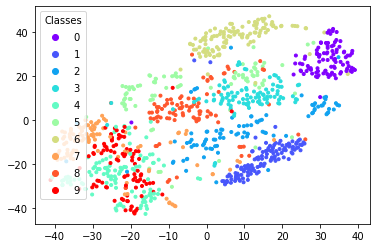

In [53]:
from sklearn.manifold import TSNE
X_vis = TSNE(n_components=2).fit_transform(X_train[:1000])
scatter = plt.scatter(X_vis[:,0],X_vis[:,1], marker='.',c=np.array(y_train[:1000],dtype='int32'), cmap='rainbow')
plt.legend(*scatter.legend_elements(), title="Classes")

### Baseline: No Dimensionality Reduction

In [54]:
_=test_model((X_train, y_train), (X_val, y_val))

Training on 5000 datapoints in 784 dimensions.
Fitting to training data took 2.76 seconds
Training accuracy: 0.5716
Testing on 1000 datapoints.
Predicting labels for test data took 0.02194166 seconds
Testing accuracy: 0.568


### Experiment 1: PCA

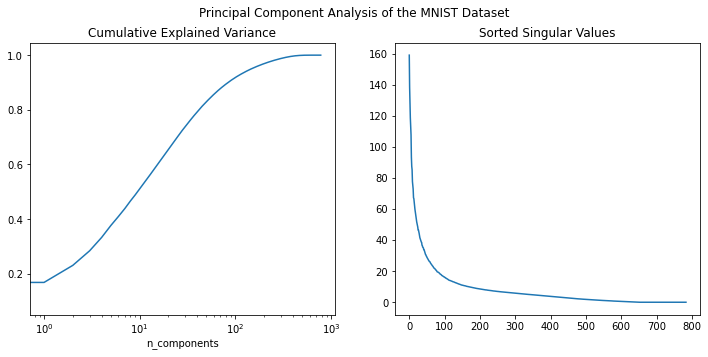

In [62]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_train)
EV = pca.explained_variance_ratio_
σ = pca.singular_values_
fig, axs = plt.subplots(1,2, figsize=(12,5))
axs[0].plot(np.cumsum(EV))
axs[0].set_title("Cumulative Explained Variance")
axs[0].set_xlabel("n_components")
axs[0].set_xscale('log')

axs[1].plot(σ)
axs[1].set_title("Sorted Singular Values")

fig.suptitle("Principal Component Analysis of the MNIST Dataset")
plt.savefig("MNIST_SVD.eps")

plt.show()

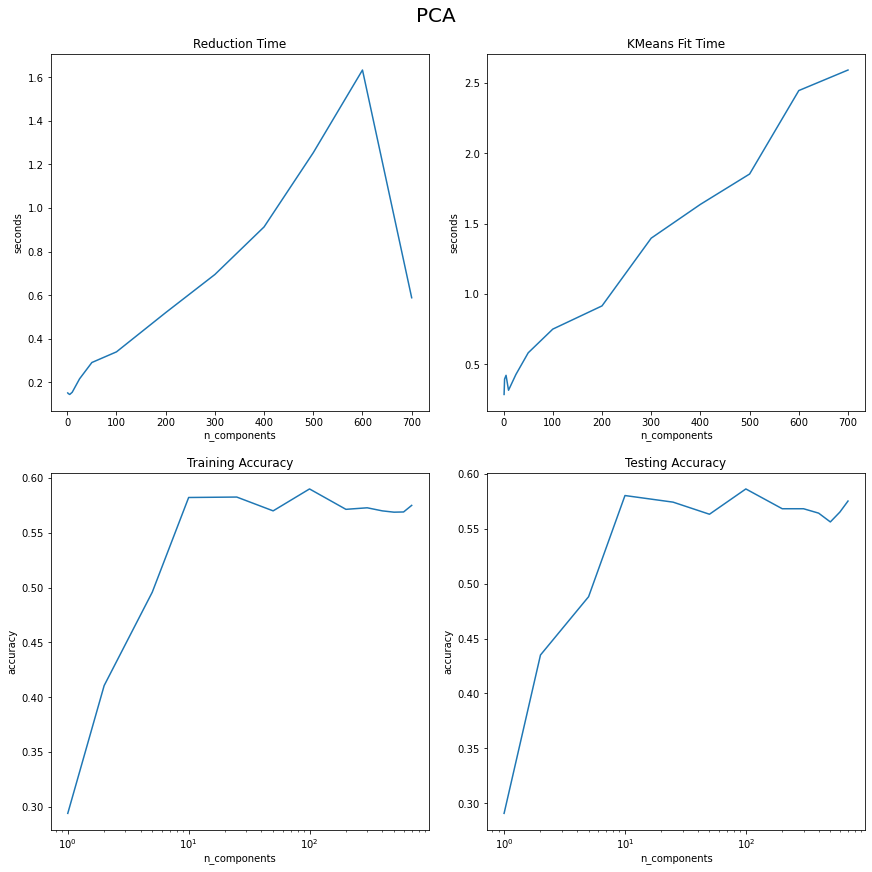

In [63]:
dims = [1,2,5,10,25,50,100,200,300,400,500,600,700]
reduce_times, fit_times, train_accs, test_accs = [], [], [], []
for dim in dims:
    print("Evaluating PCA with n_components = %i" % dim, end='\r')
    dim_reducer = PCA(n_components=dim)
    reduce_time, fit_time, train_acc, test_acc = test_model((X_train,y_train), (X_val, y_val), dim_reducer, verbose=False)
    reduce_times.append(reduce_time)
    fit_times.append(fit_time)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

PCAdata = {}
PCAdata['reduce_times'] = reduce_times
PCAdata['fit_times'] = fit_times
PCAdata['train_accs'] = train_accs
PCAdata['test_accs'] = test_accs

plot(dims, PCAdata, filename='PCA')

### Experiment 2: Kernel PCA

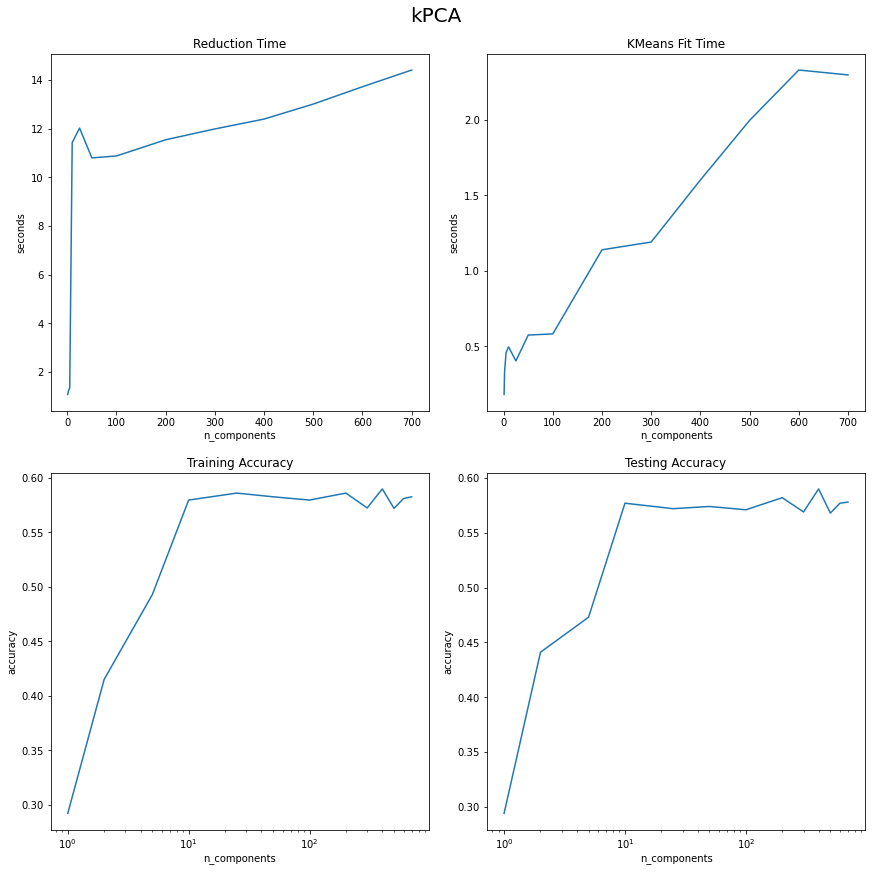

In [59]:
from sklearn.decomposition import KernelPCA
dims = [1,2,5,10,25,50,100,200,300,400,500,600,700]
reduce_times, fit_times, train_accs, test_accs = [], [], [], []
for dim in dims:
    print("Evaluating KernelPCA with n_components = %i" % dim, end='\r')
    dim_reducer = KernelPCA(n_components=dim, eigen_solver='auto')
    reduce_time, fit_time, train_acc, test_acc = test_model((X_train,y_train), (X_val, y_val), dim_reducer, verbose=False)
    reduce_times.append(reduce_time)
    fit_times.append(fit_time)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
kPCA = {}
kPCA['reduce_times'] = reduce_times
kPCA['fit_times'] = fit_times
kPCA['train_accs'] = train_accs
kPCA['test_accs'] = test_accs

plot(dims, kPCA, filename='kPCA')

### Experiment 3: NMF

C:\Users\rossi\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


C:\Users\rossi\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


C:\Users\rossi\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


C:\Users\rossi\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


C:\Users\rossi\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


C:\Users\rossi\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


C:\Users\rossi\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
C:\Users\rossi\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


C:\Users\rossi\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
C:\Users\rossi\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


C:\Users\rossi\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
C:\Users\rossi\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


C:\Users\rossi\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
C:\Users\rossi\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


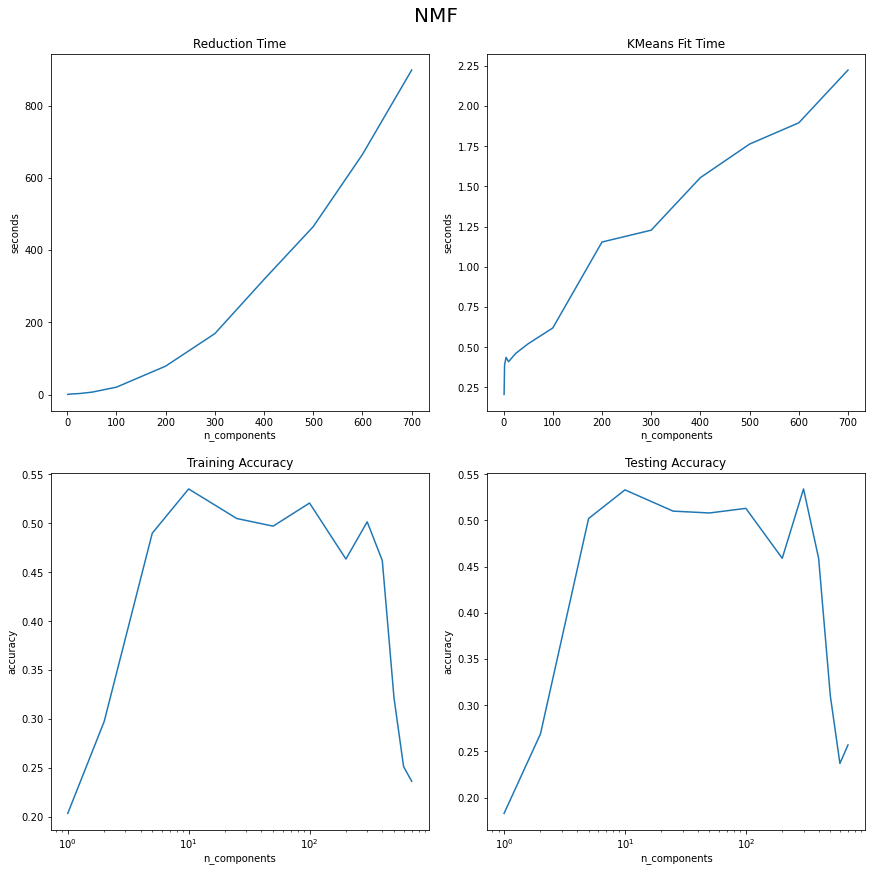

In [67]:
from sklearn.decomposition import NMF
dims = [1,2,5,10,25,50,100,200,300,400,500,600,700]
reduce_times, fit_times, train_accs, test_accs = [], [], [], []
for dim in dims:
    print("Evaluating NMF with n_components = %i" % dim, end='\r')
    dim_reducer = NMF(n_components=dim)
    reduce_time, fit_time, train_acc, test_acc = test_model((X_train,y_train), (X_val, y_val), dim_reducer, verbose=False)
    reduce_times.append(reduce_time)
    fit_times.append(fit_time)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
    
NMF = {}
NMF['reduce_times'] = reduce_times
NMF['fit_times'] = fit_times
NMF['train_accs'] = train_accs
NMF['test_accs'] = test_accs

plot(dims, NMF, filename='NMF')

### Experiment 4: t-SNE

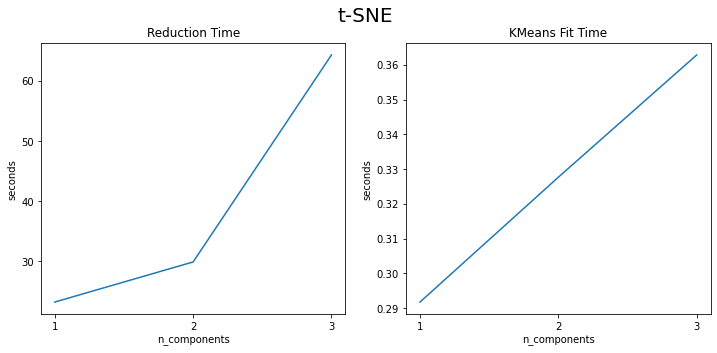

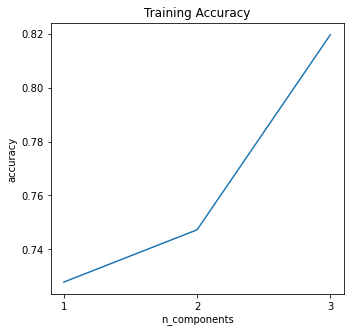

In [116]:
dims = [1,2,3]
reduce_times, fit_times, train_accs, test_accs = [], [], [], []
for dim in dims:
    print("Evaluating t-SNE with n_components = %i" % dim, end='\r')
    dim_reducer = TSNE(n_components=dim)
    reduce_time, fit_time, train_acc, test_acc = test_model((X_train,y_train), None, dim_reducer,
                                                            prereduce=True, verbose=False)
    reduce_times.append(reduce_time)
    fit_times.append(fit_time)
    train_accs.append(train_acc)

tSNE = {}
tSNE['reduce_times'] = reduce_times
tSNE['fit_times'] = fit_times
tSNE['train_accs'] = train_accs
tSNE['test_accs'] = test_accs
    
fig1, axs = plt.subplots(1, 2, figsize=(12,5))
fig1.suptitle("t-SNE", fontsize=20)

axs[0].plot(dims, reduce_times)
axs[0].set_xticks([1,2,3])
axs[0].set_title("Reduction Time")
axs[0].set_xlabel("n_components")
axs[0].set_ylabel("seconds")
    
axs[1].plot(dims, fit_times)
axs[1].set_xticks([1,2,3])
axs[1].set_title("KMeans Fit Time")
axs[1].set_xlabel("n_components")
axs[1].set_ylabel("seconds")
plt.savefig(fname='t-SNE1.eps')

fig2, ax3 = plt.subplots(figsize=(5.25,5))
ax3.plot(dims, train_accs)
ax3.set_xticks([1,2,3])
ax3.set_title("Training Accuracy")
ax3.set_xlabel("n_components")
ax3.set_ylabel("accuracy")

plt.savefig(fname='t-SNE2.eps')